In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aapl-5y-stocks/aapl_us_d.csv
/kaggle/input/apple/aapl_us_d.csv


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

plt.style.use("seaborn-v0_8")


In [60]:
import os
for root, dirs, files in os.walk("/kaggle/input"):
    for f in files:
        print(os.path.join(root, f))


/kaggle/input/aapl-5y-stocks/aapl_us_d.csv
/kaggle/input/apple/aapl_us_d.csv


In [61]:
# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Sort chronologically
df = df.sort_index()

# Set daily frequency (fixes statsmodels warning)
df = df.asfreq("D")

# Forward-fill weekends/holidays
df["Close"] = df["Close"].ffill()

# Final time series
ts = df["Close"]

ts.head()


Date
1984-09-07    0.099605
1984-09-08    0.099605
1984-09-09    0.099605
1984-09-10    0.099014
1984-09-11    0.100827
Freq: D, Name: Close, dtype: float64

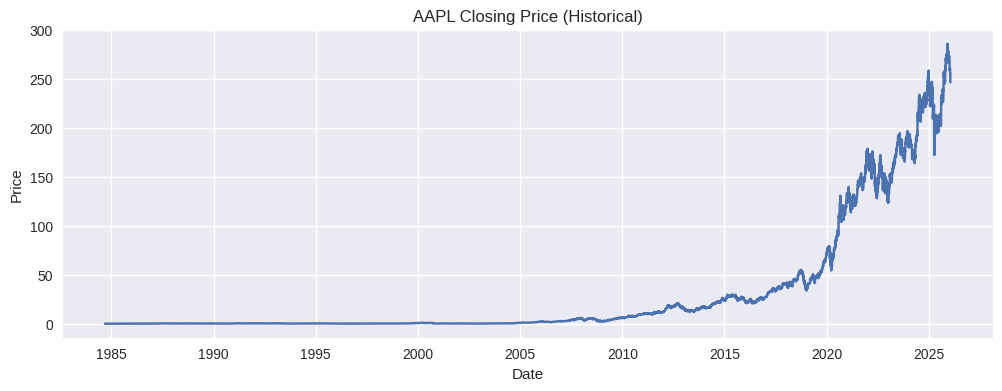

In [62]:
plt.figure(figsize=(12,4))
plt.plot(ts)
plt.title("AAPL Closing Price (Historical)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [63]:
split = int(len(ts) * 0.8)

train = ts.iloc[:split]
test = ts.iloc[split:]

len(train), len(test)


(12088, 3023)

In [64]:
model = SARIMAX(
    train,
    order=(1,1,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


In [67]:
pred = results.get_prediction(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)

pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()


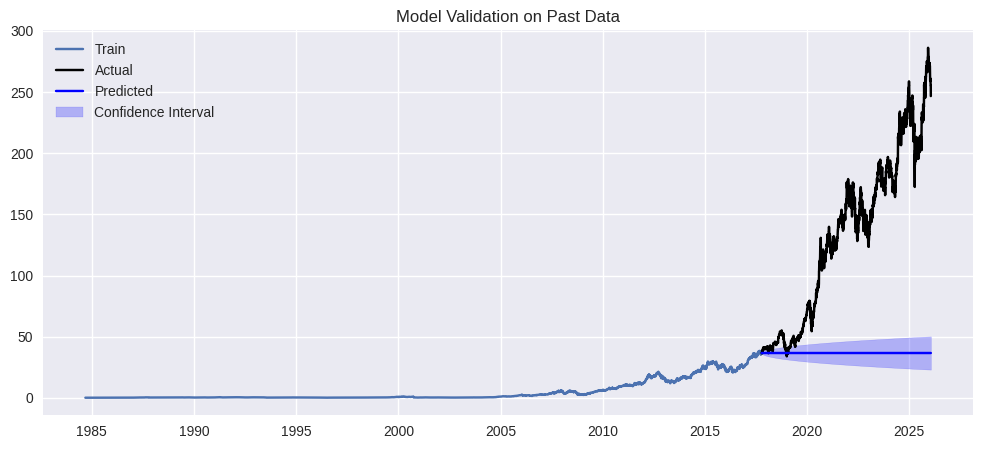

In [68]:
plt.figure(figsize=(12,5))

plt.plot(train, label="Train")
plt.plot(test, label="Actual", color="black")
plt.plot(pred_mean, label="Predicted", color="blue")

plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:,0],
    pred_ci.iloc[:,1],
    color="blue",
    alpha=0.25,
    label="Confidence Interval"
)

plt.legend()
plt.title("Model Validation on Past Data")
plt.show()


In [69]:
mae = mean_absolute_error(test, pred_mean)
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 97.57856428466587


In [71]:
forecast = results.get_forecast(steps=7)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


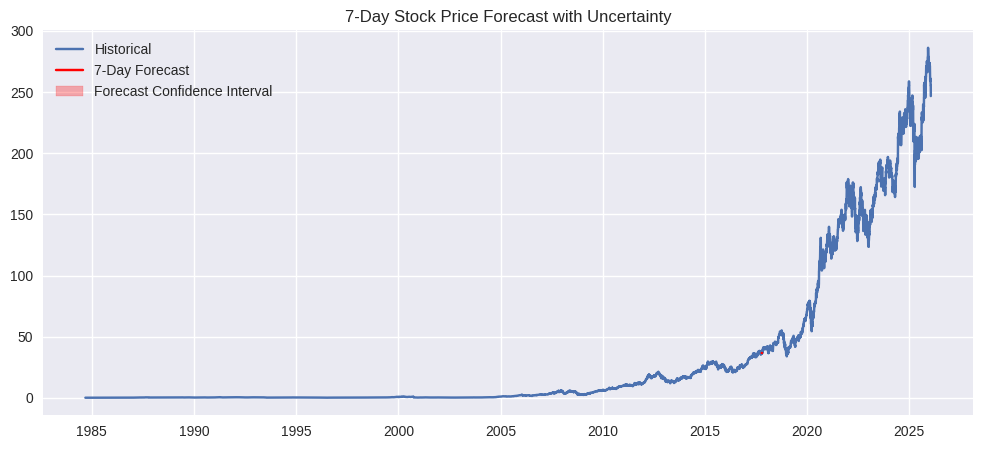

In [72]:
plt.figure(figsize=(12,5))

plt.plot(ts, label="Historical")
plt.plot(forecast_mean, label="7-Day Forecast", color="red")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:,0],
    forecast_ci.iloc[:,1],
    color="red",
    alpha=0.3,
    label="Forecast Confidence Interval"
)

plt.legend()
plt.title("7-Day Stock Price Forecast with Uncertainty")
plt.show()


TASK 2

In [73]:
# Rolling volatility (risk proxy)
rolling_vol = ts.pct_change().rolling(window=20).std()

# Recent trend (last 30 days slope)
recent_prices = ts[-30:]
trend_slope = np.polyfit(range(len(recent_prices)), recent_prices.values, 1)[0]

# Confidence interval width
ci_width = forecast_ci.iloc[:,1] - forecast_ci.iloc[:,0]
avg_ci_width = ci_width.mean()

trend_slope, avg_ci_width


(np.float64(-0.8261512791991161), np.float64(0.9500504668403705))

In [76]:
def generate_financial_explanation(trend_slope, avg_ci_width, rolling_vol):
    explanations = []

    if trend_slope > 0:
        explanations.append(
            "The model identifies a recent upward trend, indicating positive short-term momentum."
        )
    else:
        explanations.append(
            "The model identifies a flat or downward trend, suggesting cautious short-term outlook."
        )

    recent_vol = rolling_vol[-20:].mean()
    if recent_vol > rolling_vol.mean():
        explanations.append(
            "Recent volatility is higher than average, increasing uncertainty in the forecast."
        )
    else:
        explanations.append(
            "Market volatility is relatively stable, leading to more confident predictions."
        )

    explanations.append(
        f"The confidence interval reflects forecast uncertainty, with an average width of approximately {avg_ci_width:.2f} price units."
    )

    explanations.append(
        "These insights are based solely on historical prices and do not account for external events such as news or earnings."
    )

    return explanations


In [77]:
advisor_insights = generate_financial_explanation(
    trend_slope,
    avg_ci_width,
    rolling_vol
)

print("📊 Financial Advisor Insights:\n")
for i, insight in enumerate(advisor_insights, 1):
    print(f"{i}. {insight}")


📊 Financial Advisor Insights:

1. The model identifies a flat or downward trend, suggesting cautious short-term outlook.
2. Market volatility is relatively stable, leading to more confident predictions.
3. The confidence interval reflects forecast uncertainty, with an average width of approximately 0.95 price units.
4. These insights are based solely on historical prices and do not account for external events such as news or earnings.
